<a href="https://colab.research.google.com/github/adampotton/MDM3-Rep-3/blob/main/logit_combo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from google.colab import files, drive
import json
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
drive.mount('/content/drive')

Mounted at /content/drive


### Load everything

In [3]:
S2_logits = np.load('/content/drive/My Drive/Aerial Data/S2_99_logits.npy')
A_logits = np.load('/content/drive/My Drive/Aerial Data/aerial_99_logits.npy')

with open('/content/drive/My Drive/Aerial Data/Both Imagery/datapoints.json', 'r') as f:
    data = json.load(f)

A_logits = A_logits[[item[2] for item in data]]

true_labels = [item[1] for item in data]
unique_trees, true_labels_numeric = np.unique(true_labels, return_inverse=True)
number_to_tree = {i: species for i, species in enumerate(unique_trees)}

mapping = pd.read_csv('/content/drive/My Drive/S2 Data/tree_mapping.csv')
df = pd.DataFrame(mapping)

# Species Level (19 classes)

### Accuracies

In [ ]:
accuracy_S2 = np.mean(np.argmax(S2_logits, axis=1) == true_labels_numeric)
accuracy_A = np.mean(np.argmax(A_logits, axis=1) == true_labels_numeric)

print("Accuracy for S2 model: {:.5f}%".format(accuracy_S2*100))
print("Accuracy for Aerial model: {:.5f}%".format(accuracy_A*100))

Accuracy for S2 model: 75.55150%
Accuracy for Aerial model: 63.32137%


### True label class frequency

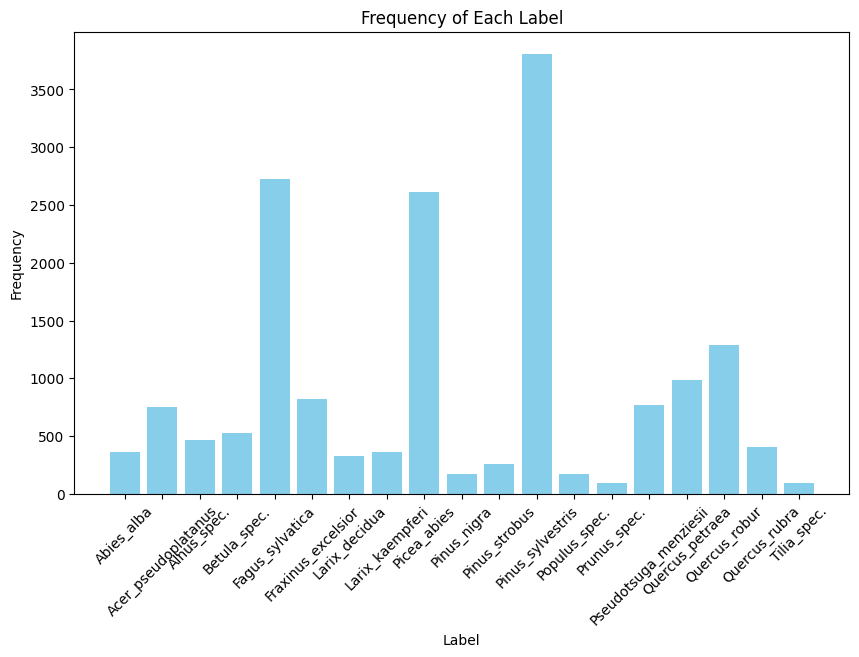

In [ ]:
unique_labels, label_counts = np.unique(true_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.title('Frequency of Each Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Combine logits with mean



In [ ]:
av_logits = (S2_logits + A_logits) / 2
av_predicted = np.argmax(av_logits, axis=1)
accuracy_av = np.mean(av_predicted == true_labels_numeric)
print("Mean logits accuracy: {:.5f}%".format(accuracy_av*100))

Mean logits accuracy: 75.84564%


### Combine logits with weighted mean

In [ ]:
weight_S2 = 0.7
weight_A = 1 - weight_S2

w_av_logits = (weight_S2 * S2_logits) + (weight_A * A_logits)
w_av_predicted = np.argmax(w_av_logits, axis=1)
accuracy_w_av = np.mean(w_av_predicted == true_labels_numeric)

print("Combined logits accuracy (weighted averaging): {:.6f}%".format(accuracy_w_av * 100))

Combined logits accuracy (weighted averaging): 79.028178%


# Hierarchical (all 4 classification types)

### Class mapping functions and getting predictions

In [52]:
def map_tree_name(name, classification):
    name = name.replace('_', ' ')
    row_number = df.index[df['Species'] == name][0]
    if classification == 0:
        return name
    elif classification == 1:
        return df.iloc[row_number, 1]
    elif classification == 2:
        return df.iloc[row_number, 2]
    elif classification == 3:
        return df.iloc[row_number, 3]

def apply_mapping(names, classification):
    return np.array([map_tree_name(name, classification) for name in names])

lab_14 = apply_mapping(true_labels,1)
lab_9 = apply_mapping(true_labels,2)
lab_2 = apply_mapping(true_labels,3)

true_labels_19 = true_labels_numeric
_, true_labels_14 = np.unique(lab_14, return_inverse=True)
_, true_labels_9 = np.unique(lab_9, return_inverse=True)
_, true_labels_2 = np.unique(lab_2, return_inverse=True)

S2_pred_19 = np.argmax(S2_logits, axis=1)
A_pred_19 = np.argmax(A_logits, axis=1)
_,S2_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(S2_logits, axis=1)],1), return_inverse=True)
_,A_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(A_logits, axis=1)],1), return_inverse=True)
_,S2_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(S2_logits, axis=1)],2), return_inverse=True)
_,A_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(A_logits, axis=1)],2), return_inverse=True)
_,S2_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(S2_logits, axis=1)],3), return_inverse=True)
_,A_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(A_logits, axis=1)],3), return_inverse=True)

av_logits = (S2_logits + A_logits) / 2
_,av_pred_19 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],0), return_inverse=True)
_,av_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],1), return_inverse=True)
_,av_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],2), return_inverse=True)
_,av_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],3), return_inverse=True)

w_av_logits = (0.81*S2_logits + 0.19*A_logits)
_,w_av_pred_19 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)],0), return_inverse=True)
_,w_av_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)],1), return_inverse=True)
_,w_av_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)],2), return_inverse=True)
_,w_av_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)],3), return_inverse=True)

### Accuracies

In [ ]:
accuracies = {
    "S2_19": np.mean(S2_pred_19 == true_labels_19),
    "A_19": np.mean(A_pred_19 == true_labels_19),
    "Average_19": np.mean(av_pred_19 == true_labels_19),
    "Weighted_Av_19": np.mean(w_av_pred_19 == true_labels_19),
    "RF_19": accuracies_RF[0],
    "LR_19": accuracies_LR[0],
    "S2_14": np.mean(S2_pred_14 == true_labels_14),
    "A_14": np.mean(A_pred_14 == true_labels_14),
    "Average_14": np.mean(av_pred_14 == true_labels_14),
    "Weighted_Av_14": np.mean(w_av_pred_14 == true_labels_14),
    "RF_14": accuracies_RF[1],
    "LR_14": accuracies_LR[1],
    "S2_9": np.mean(S2_pred_9 == true_labels_9),
    "A_9": np.mean(A_pred_9 == true_labels_9),
    "Average_9": np.mean(av_pred_9 == true_labels_9),
    "Weighted_Av_9": np.mean(w_av_pred_9 == true_labels_9),
    "RF_9": accuracies_RF[2],
    "LR_9": accuracies_LR[2],
    "S2_2": np.mean(S2_pred_2 == true_labels_2),
    "A_2": np.mean(A_pred_2 == true_labels_2),
    "Average_2": np.mean(av_pred_2 == true_labels_2),
    "Weighted_Av_2": np.mean(w_av_pred_2 == true_labels_2),
    "RF_2": accuracies_RF[3],
    "LR_2": accuracies_LR[3],
}

print("Model\t\t\tAccuracy")
print("-" * 33)
for model, accuracy in accuracies.items():
    print(f"{model}\t\t\t{accuracy * 100:.5f}%")



Model			Accuracy
---------------------------------
S2_19			75.55150%
A_19			63.32137%
Average_19			75.84564%
Weighted_Av_19			79.58115%
S2_14			79.80469%
A_14			66.85687%
Average_14			79.66351%
Weighted_Av_14			83.14018%
S2_9			81.98129%
A_9			68.29225%
Average_9			81.45773%
Weighted_Av_9			85.02853%
S2_2			96.70569%
A_2			91.99953%
Average_2			96.59980%
Weighted_Av_2			97.39985%


### Plot Bar Chart

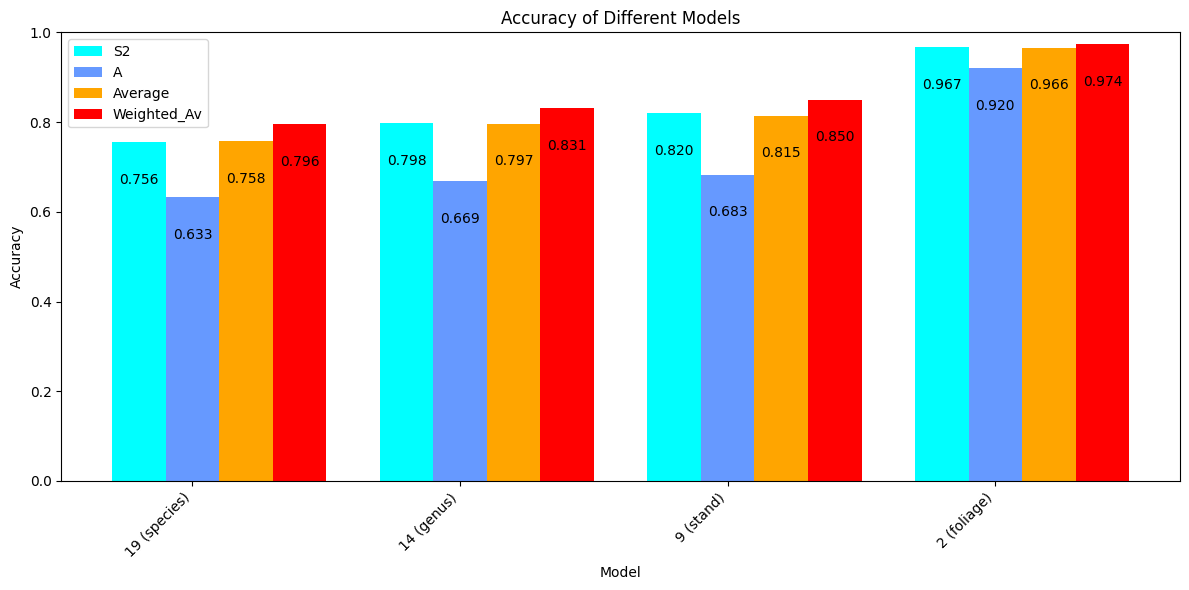

In [ ]:
models = ["19 (species)", "14 (genus)", "9 (stand)", "2 (foliage)"]
accuracies_values = [accuracies[f"{model}_19"] for model in ["S2", "A", "Average", "Weighted_Av"]]
accuracies_values += [accuracies[f"{model}_14"] for model in ["S2", "A", "Average", "Weighted_Av"]]
accuracies_values += [accuracies[f"{model}_9"] for model in ["S2", "A", "Average", "Weighted_Av"]]
accuracies_values += [accuracies[f"{model}_2"] for model in ["S2", "A", "Average", "Weighted_Av"]]

x = np.arange(len(models))
bar_width = 0.2

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width, accuracies_values[::4], bar_width, label='S2', color='cyan')
bars2 = plt.bar(x, accuracies_values[1::4], bar_width, label='A', color='#6699FF')
bars3 = plt.bar(x + bar_width, accuracies_values[2::4], bar_width, label='Average', color='orange')
bars4 = plt.bar(x + 2 * bar_width, accuracies_values[3::4], bar_width, label='Weighted_Av', color='red')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)
plt.xticks(np.arange(len(models)), models, rotation=45, ha='right')
plt.legend()

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.1, '{:.3f}'.format(bar.get_height()), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

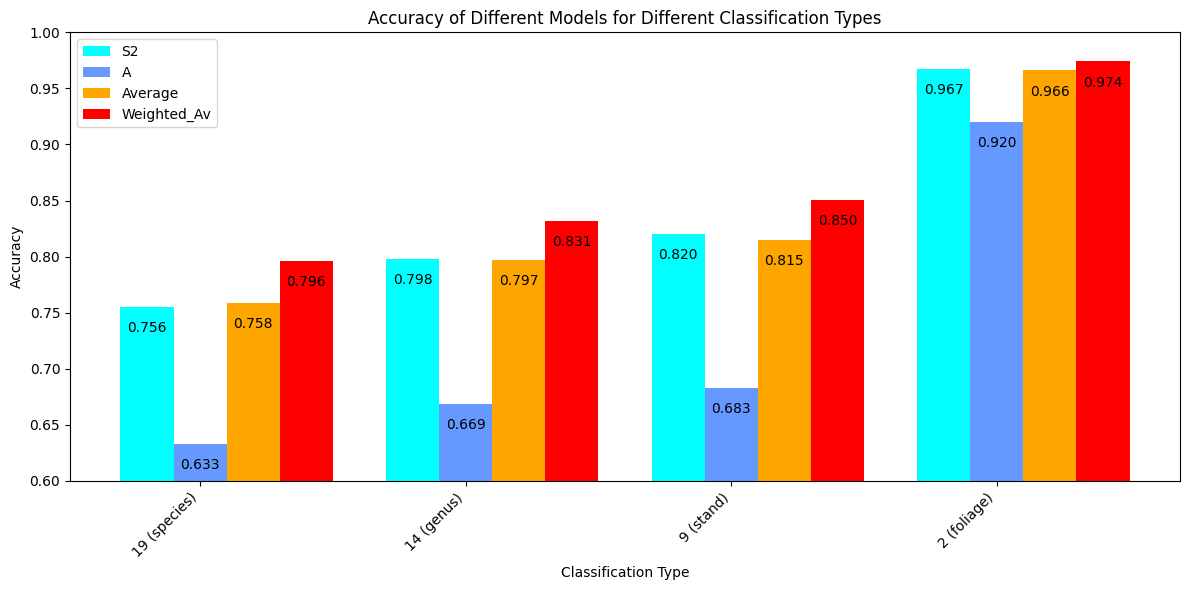

In [ ]:
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width, accuracies_values[::4], bar_width, label='S2', color='cyan')
bars2 = plt.bar(x, accuracies_values[1::4], bar_width, label='A', color='#6699FF')
bars3 = plt.bar(x + bar_width, accuracies_values[2::4], bar_width, label='Average', color='orange')
bars4 = plt.bar(x + 2 * bar_width, accuracies_values[3::4], bar_width, label='Weighted_Av', color='red')

plt.xlabel('Classification Type')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models for Different Classification Types')
plt.ylim(0.6, 1)
plt.xticks(np.arange(len(models)), models, rotation=45, ha='right')
plt.legend()

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.025, '{:.3f}'.format(bar.get_height()), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# ML to Combine Logits

### Random Forest

In [53]:
classifications = [true_labels_19,true_labels_14,true_labels_9,true_labels_2]
class_names = ['Species','Genus','Stand Type','Foliage']
accuracies_RF = []

for i in range(4):

    labels_x = classifications[i]
    name = class_names[i]

    stacked_features = np.column_stack((A_logits[:, :], S2_logits[:, :]))

    X_train, X_test, y_train, y_test = train_test_split(stacked_features, labels_x, test_size=0.2, random_state=13)

    meta_model = RandomForestClassifier(random_state=13)
    meta_model.fit(X_train, y_train)

    final_preds = meta_model.predict(X_test)

    accuracy = accuracy_score(y_test, final_preds)
    accuracies_RF.append(accuracy)
    print(f"{name}{': '}{accuracy * 100:.5f}%")


Species: 79.47059%
Genus: 82.79412%
Stand Type: 85.08824%
Foliage: 97.73529%


### Logistic Regression

In [54]:
classifications = [true_labels_19,true_labels_14,true_labels_9,true_labels_2]
class_names = ['Species','Genus','Stand Type','Foliage']
accuracies_LR = []

for i in range(4):

    labels_x = classifications[i]
    name = class_names[i]

    stacked_features = np.column_stack((A_logits[:, :], S2_logits[:, :]))

    X_train, X_test, y_train, y_test = train_test_split(stacked_features, labels_x, test_size=0.2, random_state=42)

    meta_model = LogisticRegression(random_state=42, max_iter=5000)
    meta_model.fit(X_train, y_train)

    final_preds = meta_model.predict(X_test)

    accuracy = accuracy_score(y_test, final_preds)
    accuracies_LR.append(accuracy)
    print(f"{name}{': '}{accuracy * 100:.5f}%")

Species: 84.08824%
Genus: 86.32353%
Stand Type: 87.50000%
Foliage: 96.82353%


### Bar Chart for ML results

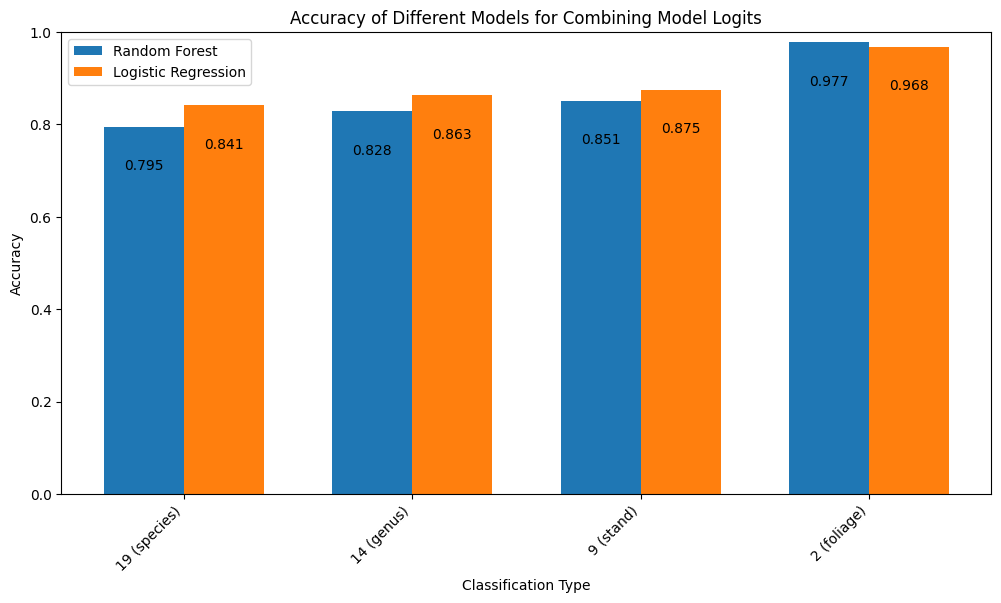

In [ ]:
models = ["19 (species)", "14 (genus)", "9 (stand)", "2 (foliage)"]

x = np.arange(len(models))
bar_width = 0.35

plt.figure(figsize=(12, 6))

bars_RF = plt.bar(x - bar_width/2, accuracies_RF, bar_width, label='Random Forest')
bars_LR = plt.bar(x + bar_width/2, accuracies_LR, bar_width, label='Logistic Regression')

plt.xlabel('Classification Type')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models for Combining Model Logits')
plt.ylim(0, 1)
plt.xticks(np.arange(len(models)), models, rotation=45, ha='right')
plt.legend()

# Add text labels for each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height - 0.1, '{:.3f}'.format(height), ha='center', va='bottom', color='black')

add_labels(bars_RF)
add_labels(bars_LR)

# Weighted Average Grid Search

In [3]:
def map_tree_name(name, classification):
    name = name.replace('_', ' ')
    row_number = df.index[df['Species'] == name][0]
    if classification == 0:
        return name
    elif classification == 1:
        return df.iloc[row_number, 1]
    elif classification == 2:
        return df.iloc[row_number, 2]
    elif classification == 3:
        return df.iloc[row_number, 3]

def apply_mapping(names, classification):
    return np.array([map_tree_name(name, classification) for name in names])

lab_14 = apply_mapping(true_labels,1)
lab_9 = apply_mapping(true_labels,2)
lab_2 = apply_mapping(true_labels,3)

true_labels_19 = true_labels_numeric
_, true_labels_14 = np.unique(lab_14, return_inverse=True)
_, true_labels_9 = np.unique(lab_9, return_inverse=True)
_, true_labels_2 = np.unique(lab_2, return_inverse=True)

S2_pred_19 = np.argmax(S2_logits, axis=1)
A_pred_19 = np.argmax(A_logits, axis=1)
_,S2_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(S2_logits, axis=1)],1), return_inverse=True)
_,A_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(A_logits, axis=1)],1), return_inverse=True)
_,S2_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(S2_logits, axis=1)],2), return_inverse=True)
_,A_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(A_logits, axis=1)],2), return_inverse=True)
_,S2_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(S2_logits, axis=1)],3), return_inverse=True)
_,A_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(A_logits, axis=1)],3), return_inverse=True)

av_logits = (S2_logits + A_logits) / 2
_,av_pred_19 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],0), return_inverse=True)
_,av_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],1), return_inverse=True)
_,av_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],2), return_inverse=True)
_,av_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],3), return_inverse=True)


In [4]:

# Generate combinations of weights
combos = []
w = np.arange(0, 1.02, 0.02)
for i in range(51):
    combos.append([1 - w[i], w[i]])

# Initialize lists to store accuracies and combos for each set of numbers
accuracies_19 = []
accuracies_14 = []
accuracies_9 = []
accuracies_2 = []

combos_19 = []
combos_14 = []
combos_9 = []
combos_2 = []

# Initialize variables to store best accuracy and corresponding combo
best_acc_19 = 0
best_acc_14 = 0
best_acc_9 = 0
best_acc_2 = 0

best_combo_19 = None
best_combo_14 = None
best_combo_9 = None
best_combo_2 = None

# Iterate through each combo
for i in range(51):
    # Calculate weighted average logits
    w_av_logits = (combos[i][0] * S2_logits + combos[i][1] * A_logits)

    # Apply mapping and calculate predictions
    _,w_av_pred_19 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)], 0), return_inverse=True)
    _,w_av_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)], 1), return_inverse=True)
    _,w_av_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)], 2), return_inverse=True)
    _,w_av_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)], 3), return_inverse=True)

    # Calculate accuracies
    w_av_acc_19 = np.mean(w_av_pred_19 == true_labels_19)
    w_av_acc_14 = np.mean(w_av_pred_14 == true_labels_14)
    w_av_acc_9 = np.mean(w_av_pred_9 == true_labels_9)
    w_av_acc_2 = np.mean(w_av_pred_2 == true_labels_2)

    # Store accuracies and combos
    accuracies_19.append(w_av_acc_19)
    accuracies_14.append(w_av_acc_14)
    accuracies_9.append(w_av_acc_9)
    accuracies_2.append(w_av_acc_2)

    combos_19.append(combos[i])
    combos_14.append(combos[i])
    combos_9.append(combos[i])
    combos_2.append(combos[i])

    # Update best accuracy and corresponding combo
    if w_av_acc_19 > best_acc_19:
        best_acc_19 = w_av_acc_19
        best_combo_19 = combos[i]

    if w_av_acc_14 > best_acc_14:
        best_acc_14 = w_av_acc_14
        best_combo_14 = combos[i]

    if w_av_acc_9 > best_acc_9:
        best_acc_9 = w_av_acc_9
        best_combo_9 = combos[i]

    if w_av_acc_2 > best_acc_2:
        best_acc_2 = w_av_acc_2
        best_combo_2 = combos[i]

# Print or use the best combos and accuracies
print("Best Combo for 19:", best_combo_19, "with Accuracy:", best_acc_19)
print("Best Combo for 14:", best_combo_14, "with Accuracy:", best_acc_14)
print("Best Combo for 9:", best_combo_9, "with Accuracy:", best_acc_9)
print("Best Combo for 2:", best_combo_2, "with Accuracy:", best_acc_2)

# Save all accuracies and combos for plotting
all_accuracies = [accuracies_19, accuracies_14, accuracies_9, accuracies_2]
all_combos = [combos_19, combos_14, combos_9, combos_2]


Best Combo for 19: [0.8200000000000001, 0.18] with Accuracy: 0.7959291723042532
Best Combo for 14: [0.8200000000000001, 0.18] with Accuracy: 0.8319901170657098
Best Combo for 9: [0.8200000000000001, 0.18] with Accuracy: 0.8507559268192246
Best Combo for 2: [0.8, 0.2] with Accuracy: 0.9739984704982646


In [ ]:
accuracies = {
    "S2_19": np.mean(S2_pred_19 == true_labels_19),
    "A_19": np.mean(A_pred_19 == true_labels_19),
    "Average_19": np.mean(av_pred_19 == true_labels_19),
    "Weighted_Av_19": np.mean(w_av_pred_19 == true_labels_19),
    "S2_14": np.mean(S2_pred_14 == true_labels_14),
    "A_14": np.mean(A_pred_14 == true_labels_14),
    "Average_14": np.mean(av_pred_14 == true_labels_14),
    "Weighted_Av_14": np.mean(w_av_pred_14 == true_labels_14),
    "S2_9": np.mean(S2_pred_9 == true_labels_9),
    "A_9": np.mean(A_pred_9 == true_labels_9),
    "Average_9": np.mean(av_pred_9 == true_labels_9),
    "Weighted_Av_9": np.mean(w_av_pred_9 == true_labels_9),
    "S2_2": np.mean(S2_pred_2 == true_labels_2),
    "A_2": np.mean(A_pred_2 == true_labels_2),
    "Average_2": np.mean(av_pred_2 == true_labels_2),
    "Weighted_Av_2": np.mean(w_av_pred_2 == true_labels_2)
}

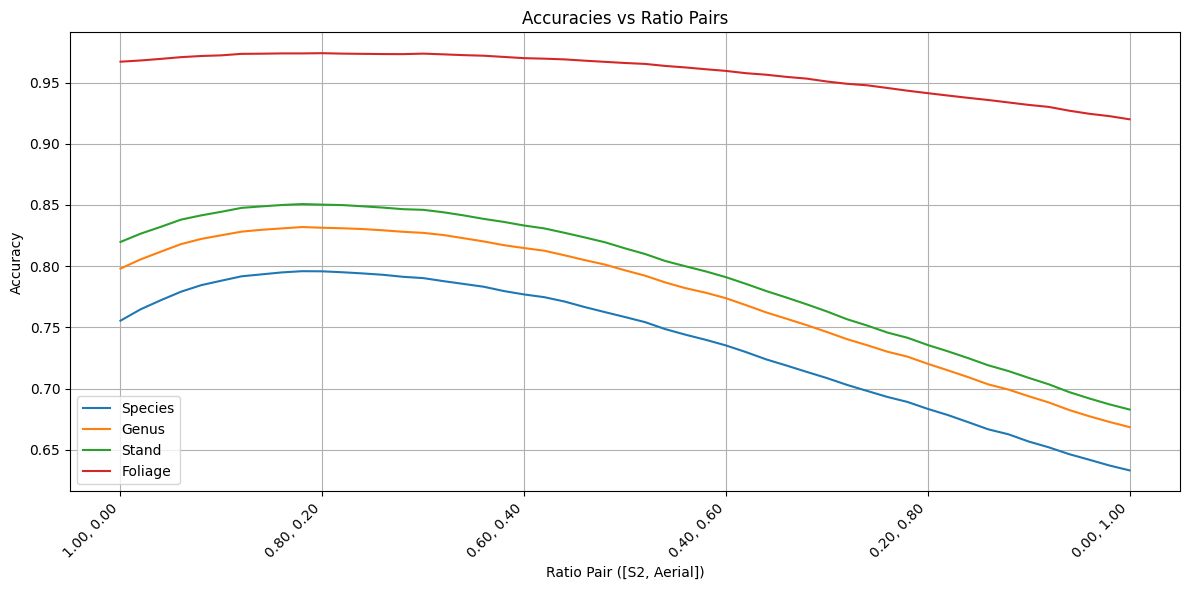

In [8]:
ratios = np.array(combos_19)

# Format ratio pairs as strings
ratio_labels = [f"{r[0]:.2f}, {r[1]:.2f}" for r in ratios]

# Plot accuracies against ratio values for each set of numbers
plt.figure(figsize=(12, 6))
plt.plot(accuracies_19, label='Species')
plt.plot(accuracies_14, label='Genus')
plt.plot(accuracies_9, label='Stand')
plt.plot(accuracies_2, label='Foliage')

# Set labels and title
plt.xlabel('Ratio Pair ([S2, Aerial])')
plt.ylabel('Accuracy')
plt.title('Accuracies vs Ratio Pairs')
plt.xticks(np.arange(len(ratio_labels))[::10], ratio_labels[::10], rotation=45, ha='right')  # Show every multiple of 10th ratio pair
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Confusion Matrix

In [ ]:
def map_tree_name(name, classification):
    name = name.replace('_', ' ')
    row_number = df.index[df['Species'] == name][0]
    if classification == 0:
        return name
    elif classification == 1:
        return df.iloc[row_number, 1]
    elif classification == 2:
        return df.iloc[row_number, 2]
    elif classification == 3:
        return df.iloc[row_number, 3]

def apply_mapping(names, classification):
    return np.array([map_tree_name(name, classification) for name in names])

lab_14 = apply_mapping(true_labels,1)
lab_9 = apply_mapping(true_labels,2)
lab_2 = apply_mapping(true_labels,3)

true_labels_19 = true_labels_numeric
_, true_labels_14 = np.unique(lab_14, return_inverse=True)
_, true_labels_9 = np.unique(lab_9, return_inverse=True)
_, true_labels_2 = np.unique(lab_2, return_inverse=True)

classifications = [true_labels_19,true_labels_14,true_labels_9,true_labels_2]
class_names = ['Species','Genus','Stand Type','Foliage']
accuracies_LR = []

for i in range(4):

    labels_x = classifications[i]
    name = class_names[i]

    stacked_features = np.column_stack((A_logits[:, :], S2_logits[:, :]))

    X_train, X_test, y_train, y_test = train_test_split(stacked_features, labels_x, test_size=0.2, random_state=42)

    meta_model = LogisticRegression(random_state=42, max_iter=5000)
    meta_model.fit(X_train, y_train)

    final_preds = meta_model.predict(X_test)

    accuracy = accuracy_score(y_test, final_preds)
    accuracies_LR.append(accuracy)
    print(f"{name}{': '}{accuracy * 100:.5f}%")

    if i == 0:
        model_19 = meta_model
    elif i == 1:
        model_14 = meta_model
    elif i == 2:
        model_9 = meta_model
    elif i == 3:
        model_2 = meta_model

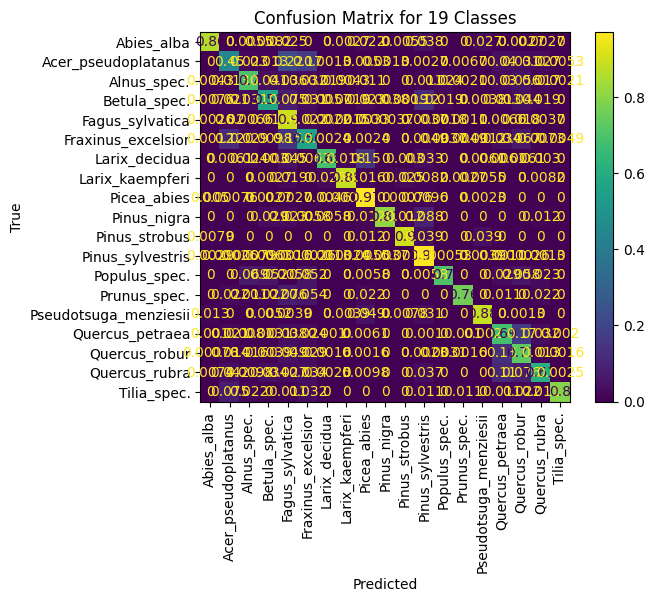

In [29]:
predictions = model_19.predict(stacked_features)

cm_19 = metrics.confusion_matrix(true_labels_19, predictions)
cm_19_norm = cm_19.astype('float') / cm_19.sum(axis=1)[:, np.newaxis]
cm_19_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_19_norm, display_labels = np.unique(true_labels))

cm_19_display.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix for 19 Classes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

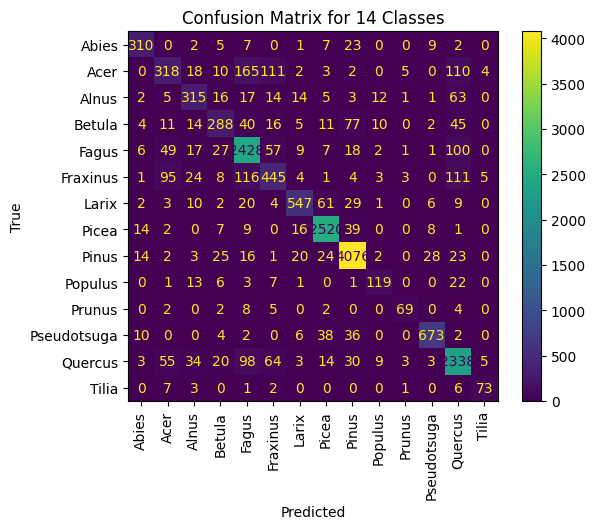

In [28]:
predictions = model_14.predict(stacked_features)

cm_14 = metrics.confusion_matrix(true_labels_14, predictions)

cm_14_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_14, display_labels = np.unique(lab_14))

cm_14_display.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix for 14 Classes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

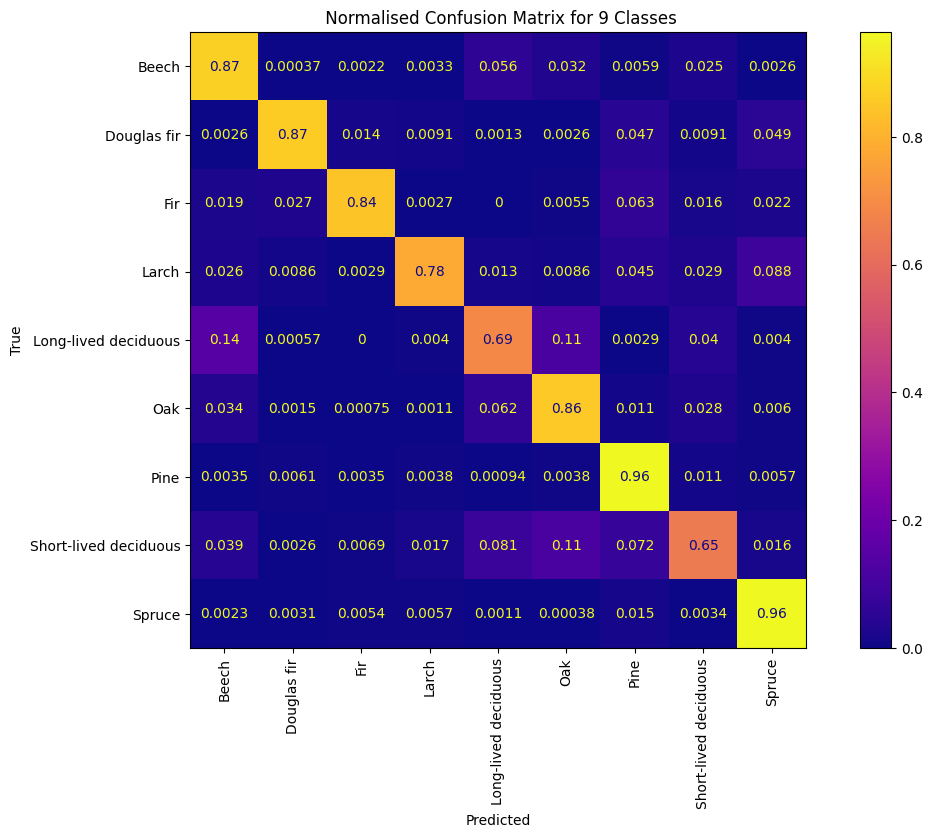

In [47]:
predictions = model_9.predict(stacked_features)

cm_9 = metrics.confusion_matrix(true_labels_9, predictions)
cm_9_norm = cm_9.astype('float') / cm_9.sum(axis=1)[:, np.newaxis]
cm_9_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_9_norm, display_labels = np.unique(lab_9))

plt.figure(figsize=(14, 8))
cm_9_display.plot(xticks_rotation='vertical',cmap='plasma', ax=plt.gca())
plt.title(' Normalised Confusion Matrix for 9 Classes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

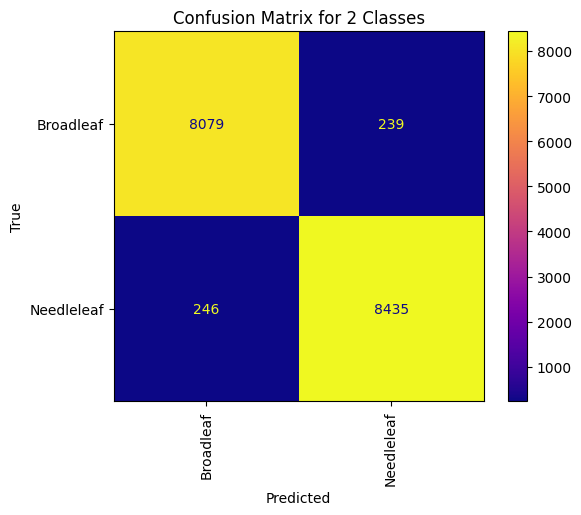

In [51]:

predictions = model_2.predict(stacked_features)

cm_2 = metrics.confusion_matrix(true_labels_2, predictions)
cm_2 = cm_2
cm_2_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_2, display_labels = np.unique(lab_2))

cm_2_display.plot(xticks_rotation='vertical',cmap='plasma', ax=plt.gca())
plt.title('Confusion Matrix for 2 Classes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# New Bar Charts

In [56]:
accuracies = {
    "S2_19": np.mean(S2_pred_19 == true_labels_19),
    "A_19": np.mean(A_pred_19 == true_labels_19),
    "Average_19": np.mean(av_pred_19 == true_labels_19),
    "Weighted_Av_19": np.mean(w_av_pred_19 == true_labels_19),
    "RF_19": accuracies_RF[0],
    "LR_19": accuracies_LR[0],
    "S2_14": np.mean(S2_pred_14 == true_labels_14),
    "A_14": np.mean(A_pred_14 == true_labels_14),
    "Average_14": np.mean(av_pred_14 == true_labels_14),
    "Weighted_Av_14": np.mean(w_av_pred_14 == true_labels_14),
    "RF_14": accuracies_RF[1],
    "LR_14": accuracies_LR[1],
    "S2_9": np.mean(S2_pred_9 == true_labels_9),
    "A_9": np.mean(A_pred_9 == true_labels_9),
    "Average_9": np.mean(av_pred_9 == true_labels_9),
    "Weighted_Av_9": np.mean(w_av_pred_9 == true_labels_9),
    "RF_9": accuracies_RF[2],
    "LR_9": accuracies_LR[2],
    "S2_2": np.mean(S2_pred_2 == true_labels_2),
    "A_2": np.mean(A_pred_2 == true_labels_2),
    "Average_2": np.mean(av_pred_2 == true_labels_2),
    "Weighted_Av_2": np.mean(w_av_pred_2 == true_labels_2),
    "RF_2": accuracies_RF[3],
    "LR_2": accuracies_LR[3],
}

In [ ]:
models = ["19 (species)", "14 (genus)", "9 (stand)", "2 (foliage)"]
classification_types = ["S2", "A", "Average", "Weighted_Av", "RF", "LR"]

# Extract accuracies for different models and classification types
accuracies_values = [accuracies[f"{classif}_19"] for classif in classification_types]
accuracies_values += [accuracies[f"{classif}_14"] for classif in classification_types]
accuracies_values += [accuracies[f"{classif}_9"] for classif in classification_types]
accuracies_values += [accuracies[f"{classif}_2"] for classif in classification_types]

x = np.arange(len(models))
bar_width = 0.14  # Adjust the bar width

plt.figure(figsize=(12, 6))
colors = ['#00FFFF', '#8A2BE2', '#3CB371', '#4682B4', '#00CED1', '#0000FF']

for i, classification_type in enumerate(classification_types):
    bars = plt.bar(x + i * bar_width, accuracies_values[i::len(classification_types)], bar_width, label=classification_type, color=colors[i])

plt.xlabel('Classification Type')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models for Different Classification Types')
plt.ylim(0.6, 1)
plt.xticks(np.arange(len(models)) + 2 * bar_width, models, rotation=45, ha='right')
plt.legend()

for i, bars in enumerate(plt.gca().containers):
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.025, '{:.3f}'.format(bar.get_height()), ha='center', va='bottom', color='black', fontsize=8)


plt.tight_layout()
plt.show()